In [ ]:
# before this i approched with dataset and then with api
# now, here we filter the data process the data using NLP and predict the pattern and according to that we made this model...

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from wordcloud import WordCloud

In [ ]:
import numpy as np
print("NumPy version:", np.__version__)


NumPy version: 2.0.2


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

### Fake news

In [ ]:
fake = pd.read_csv('/content/drive/MyDrive/fake_news_detection/Fake.csv')

In [ ]:
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [ ]:
fake.columns

Index(['title', 'text', 'subject', 'date'], dtype='object')

In [ ]:
fake['subject'].value_counts() # it shows the details how many news, how many political news, so on

,count
subject,
News,9050
politics,6841
left-news,4459
Government News,1570
US_News,783
Middle-east,778


<Axes: xlabel='count', ylabel='subject'>

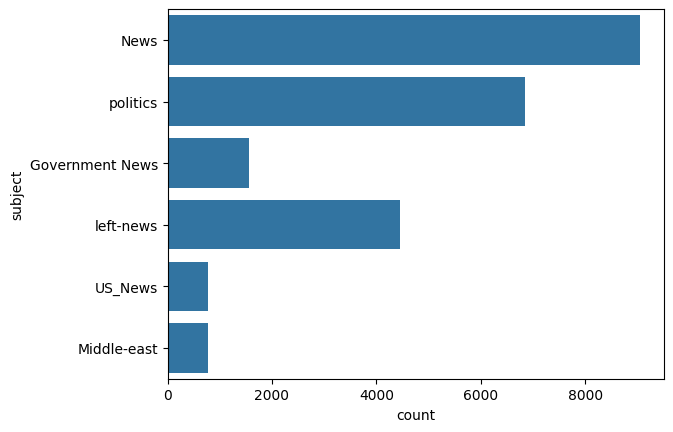

In [ ]:
sns.countplot(fake['subject'])

In [ ]:
# for textdata visualization - worldcloud

In [ ]:
text = ' '.join(fake['text'].tolist()) # this will combine all the list of fake new in a single text

In [ ]:
text

Buffered data was truncated after reaching the output size limit.

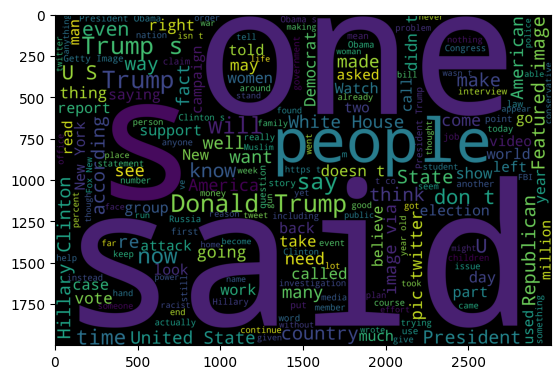

In [ ]:
wordcloud = WordCloud(width = 3000, height = 2000, random_state = 42, background_color = 'black').generate(text)
plt.imshow(wordcloud)

### True News


In [ ]:
real = pd.read_csv('/content/drive/MyDrive/fake_news_detection/True.csv')

In [ ]:
text = ' '.join(real['text'].tolist())

In [ ]:
text

Buffered data was truncated after reaching the output size limit.

In [ ]:
wordcloud = WordCloud(width = 3000, height = 2000, random_state = 42, background_color = 'black').generate(text)
plt.imshow(wordcloud)

## Difference in Text
Real news seems to have source of publication which is not present in fake news set
Looking at the data:

• most of text contains reuters information such as "WASHINGTON (Reuters)"

• Some text are tweets from Twitter

• Few text do not contain any publication info

### Cleaning Data

Removing Reuters or Twitter Tweet information from the text

• Text can be splitted only once at " - " which is always present after mentioning source of publication, this gives us publication part and

text part

• If we do not get text part, this means publication details was't given for that record

• The Twitter tweets always have same source, a long text of max 259 characters

In [ ]:
real.sample(5)

In [ ]:
unknown_publishers = []
for index, row in  enumerate(real.text.values):
  try:
    record = row.split('-', maxsplit=1) # in text atleast 1 split with '-' then there is publisher
    record[1]
    assert(len(record[0])<120) # the news should be less than 120 word

    # if this gives error the it will go to exception
  except:
    unknown_publishers.append(index)

In [ ]:
len(unknown_publishers)

In [ ]:
real.iloc[unknown_publishers].text

In [ ]:
real.iloc[8970] # row is empty - drop it

In [ ]:
real = real.drop(8970, axis=0)

In [ ]:
publisher = []
tmp_text = []
for index, row in enumerate(real.text.values):
  if index in unknown_publishers:
    publisher.append('Unknown')
    tmp_text.append(row)
  else:
    record = row.split('-', maxsplit=1)
    publisher.append(record[0].strip())
    tmp_text.append(record[1].strip())

In [ ]:
real['publisher'] = publisher
real['text'] = tmp_text

In [ ]:
real.head() # after many modifications

In [ ]:
real.shape

In [ ]:

empty_fake_index = [index for index,text in enumerate(fake.text.tolist()) if str(text).strip()==""] # this will give the data having empty lines

# it check data in the text column

In [ ]:
fake.iloc[empty_fake_index]

In [ ]:
# we have to remove this data from the data set - before giving it for traning
# giving the text - the title

In [ ]:
real['title'] + " " + real['text']

In [ ]:
fake['title'] + " " + fake['text']

In [ ]:
real['text'] = real['title'] + " " + real['text']
fake['text'] = fake['title'] + " " + fake['text']

In [ ]:
# this make the text into the lowercase

real['text'] = real['text'].apply(lambda x: str(x).lower())
fake['text'] = fake['text'].apply(lambda x: str(x).lower())

### Perprocessing Data

In [ ]:
# add the class 1 for real and 0 for fake
real['class'] = 1
fake['class'] = 0

In [ ]:
real.head()

In [ ]:
fake.head()

In [ ]:
# now for data preprocessing - we need the data from text and class only

real = real[['text', 'class']]
fake = fake[['text', 'class']]

In [ ]:
# real.append(fake, ignore_index=True) ---- giving error
data = pd.concat([real, fake], ignore_index=True) # it concatinate the data


In [ ]:
data.sample(5)

In [ ]:
# remove the character from data
import pandas as pd
import re

# Sample function to remove special characters
def remove_special_characters(text):
    return re.sub(r'[^A-Za-z0-9\s]', '', str(text))

# Example: Load your dataset (replace this with your real dataset)
# df = pd.read_csv("your_dataset.csv")

# Apply to a specific column, e.g., 'text'
data['text'] = data['text'].apply(remove_special_characters)

# If you want to preview the result
print(data['text'].head())


In [ ]:
data.sample(5)

### Vectorization - Word2Vec
Word2Vec is one of the most popular technique to learn word embeddings using shallow neural network. It was developed by Tomas Mikolov in 2013 at Google.

Word embedding is the most popular representation of document vocabulary. It is capable of capturing context of a word in a document,
semantic and syntactic similarity, relation with other words, etc.

In [ ]:
# !pip install numpy==1.26.4
# !pip install --force-reinstall --no-cache-dir gensim


In [ ]:
import gensim


In [55]:
data['class'].values

array([1, 1, 1, ..., 0, 0, 0])

In [56]:
y = data['class'].values

In [152]:
# [d.split() for d in data['text'].tolist()]   ----   all the word in the sentence


In [58]:
X = [d.split() for d in data['text'].tolist()]

In [59]:
print(X[0]) # list of words in first news

['as', 'us', 'budget', 'fight', 'looms', 'republicans', 'flip', 'their', 'fiscal', 'script', 'the', 'head', 'of', 'a', 'conservative', 'republican', 'faction', 'in', 'the', 'us', 'congress', 'who', 'voted', 'this', 'month', 'for', 'a', 'huge', 'expansion', 'of', 'the', 'national', 'debt', 'to', 'pay', 'for', 'tax', 'cuts', 'called', 'himself', 'a', 'fiscal', 'conservative', 'on', 'sunday', 'and', 'urged', 'budget', 'restraint', 'in', '2018', 'in', 'keeping', 'with', 'a', 'sharp', 'pivot', 'under', 'way', 'among', 'republicans', 'us', 'representative', 'mark', 'meadows', 'speaking', 'on', 'cbs', 'face', 'the', 'nation', 'drew', 'a', 'hard', 'line', 'on', 'federal', 'spending', 'which', 'lawmakers', 'are', 'bracing', 'to', 'do', 'battle', 'over', 'in', 'january', 'when', 'they', 'return', 'from', 'the', 'holidays', 'on', 'wednesday', 'lawmakers', 'will', 'begin', 'trying', 'to', 'pass', 'a', 'federal', 'budget', 'in', 'a', 'fight', 'likely', 'to', 'be', 'linked', 'to', 'other', 'issues',

In [61]:
DIM = 100 # dimension of the vectors
w2v_model = gensim.models.Word2Vec(sentences=X, vector_size=DIM, window=10, min_count=1)  # window means 10 words come in grp

In [62]:
len(w2v_model.wv)

230760

In [63]:
w2v_model.wv

In [64]:
w2v_model.wv['love'] # vector for the word love

array([ 3.7882168 ,  0.3063729 ,  0.06702469, -2.0478196 , -0.7046827 ,
       -1.0378225 ,  0.53444046,  0.68054587,  0.20659824,  4.529558  ,
        0.7485825 , -2.765803  , -4.2123094 , -1.8206362 ,  0.60477906,
       -0.7554942 , -1.0325674 ,  1.2111753 ,  2.7321746 , -1.6754001 ,
       -3.7231817 , -2.3114967 , -0.39407733,  1.2714458 , -0.7520706 ,
        6.093133  ,  0.88553077, -1.7814049 , -0.798776  , -2.8627288 ,
        2.827131  , -1.3384974 , -2.246646  , -0.32152358, -1.7165935 ,
        2.72997   ,  0.6303243 ,  0.41499716,  0.86058295, -1.8421763 ,
       -1.2781957 , -5.1146526 , -4.090139  , -2.0090215 , -2.3391275 ,
       -0.5826999 ,  2.1805472 , -2.3099885 , -0.22522995, -1.1250099 ,
       -0.2992647 ,  4.104486  ,  1.1819177 , -3.0862985 , -1.6991359 ,
        0.22925796, -4.61022   , -0.10974412, -3.5532184 , -0.11964508,
       -3.6518083 , -2.7116592 , -0.21219395, -2.196228  ,  0.49073535,
       -1.5858194 ,  2.2078648 ,  0.9161463 , -0.7025371 ,  2.26

In [67]:
w2v_model.wv.most_similar('love') # those are the word related to the love

[('applaud', 0.7218809723854065),
 ('thank', 0.7032722234725952),
 ('appreciate', 0.671428918838501),
 ('wish', 0.6685125827789307),
 ('admire', 0.6562840342521667),
 ('loving', 0.6110475659370422),
 ('beautiful', 0.6104397773742676),
 ('pray', 0.6093645095825195),
 ('wonderful', 0.6086299419403076),
 ('loves', 0.6034655570983887)]

In [68]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

In [69]:
X = tokenizer.texts_to_sequences(X) # change the vectors in the sequences

In [153]:
# X

In [71]:
tokenizer.word_index

{'the': 1,
 'to': 2,
 'of': 3,
 'a': 4,
 'and': 5,
 'in': 6,
 'that': 7,
 'on': 8,
 'for': 9,
 's': 10,
 'is': 11,
 'he': 12,
 'said': 13,
 'trump': 14,
 'it': 15,
 'with': 16,
 'was': 17,
 'as': 18,
 'his': 19,
 'by': 20,
 'has': 21,
 'be': 22,
 'have': 23,
 'not': 24,
 'from': 25,
 'this': 26,
 'at': 27,
 'are': 28,
 'who': 29,
 'us': 30,
 'an': 31,
 'they': 32,
 'i': 33,
 'but': 34,
 'we': 35,
 'would': 36,
 'president': 37,
 'about': 38,
 'will': 39,
 'their': 40,
 'had': 41,
 'you': 42,
 't': 43,
 'been': 44,
 'were': 45,
 'people': 46,
 'more': 47,
 'or': 48,
 'after': 49,
 'which': 50,
 'she': 51,
 'her': 52,
 'one': 53,
 'if': 54,
 'its': 55,
 'out': 56,
 'all': 57,
 'what': 58,
 'state': 59,
 'when': 60,
 'new': 61,
 'also': 62,
 'up': 63,
 'there': 64,
 'over': 65,
 'no': 66,
 'house': 67,
 'donald': 68,
 'our': 69,
 'states': 70,
 'clinton': 71,
 'obama': 72,
 'government': 73,
 'can': 74,
 'just': 75,
 'him': 76,
 'so': 77,
 'than': 78,
 'republican': 79,
 'other': 80,
 'so

In [154]:
# [len(x) for x in X]

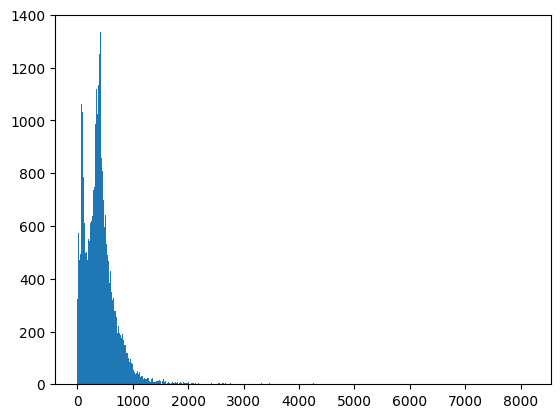

In [73]:
plt.hist([len(x) for x in X], bins = 700)
plt.show()

In [74]:
# those means the number of word repeated have that index

In [76]:
nos = np.array([len(x) for x in X])
len(nos[nos>1000])

1584

In [77]:
maxlen = 1000 #max lenth of text
X = pad_sequences(X, maxlen=maxlen)

In [78]:
len(X[103]) # length at any index will be 1000 only

1000

In [79]:
# in the news there will be the words which will be not there in the sequence the it will be treated as unknown and another sequence will me made for it

In [82]:
vocab_size = len(tokenizer.word_index) + 1
vocab = tokenizer.word_index

In [81]:
# in the model we have to feed the vector as the weight

In [83]:
def get_weight_matrix(model):
  weight_matrix = np.zeros((vocab_size, DIM)) # this would have be the tuple

  for word, i in vocab.items():
    weight_matrix[i] = model.wv[word]

  return weight_matrix

In [84]:
get_weight_matrix(w2v_model)

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 8.02031457e-01,  6.59761369e-01, -1.51162481e+00, ...,
        -1.80055606e+00, -7.09993422e-01,  5.60894430e-01],
       [ 1.04953074e+00, -3.49350810e-01,  6.34146929e-01, ...,
         2.90447474e+00, -1.39665616e+00, -5.49115287e-03],
       ...,
       [-8.98306258e-03, -3.80772017e-02,  3.59434146e-03, ...,
         3.39261722e-03,  1.58835277e-02, -1.98636372e-02],
       [-2.16838904e-03, -6.13326160e-03,  2.62322277e-02, ...,
         2.68871672e-02, -8.54433235e-03, -6.74092676e-03],
       [ 8.70739762e-03,  7.57297641e-03, -1.07121421e-02, ...,
        -1.77383833e-02,  2.65517458e-02, -1.67639693e-03]])

In [85]:
embedding_vectors = get_weight_matrix(w2v_model)

In [86]:
embedding_vectors.shape

(230761, 100)

In [92]:
# creating the model

model = Sequential()
model.add(Embedding(vocab_size, output_dim = DIM, weights=[embedding_vectors], input_length=maxlen, trainable=False)) # trainable=false means the model don't gonna be retrain
model.add(LSTM(units=128))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [93]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │      23,076,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,076,100 (88.03 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,076,100 (88.03 MB)

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [96]:
model.fit(X_train, y_train, validation_split= 0.3, epochs=6)

Epoch 1/6
786/786 ━━━━━━━━━━━━━━━━━━━━ 47s 53ms/step - acc: 0.9251 - loss: 0.1936 - val_acc: 0.9762 - val_loss: 0.0685
Epoch 2/6
786/786 ━━━━━━━━━━━━━━━━━━━━ 74s 46ms/step - acc: 0.9767 - loss: 0.0685 - val_acc: 0.9805 - val_loss: 0.0506
Epoch 3/6
786/786 ━━━━━━━━━━━━━━━━━━━━ 30s 38ms/step - acc: 0.9871 - loss: 0.0405 - val_acc: 0.9867 - val_loss: 0.0402
Epoch 4/6
786/786 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - acc: 0.9901 - loss: 0.0282 - val_acc: 0.9906 - val_loss: 0.0291
Epoch 5/6
786/786 ━━━━━━━━━━━━━━━━━━━━ 40s 39ms/step - acc: 0.9938 - loss: 0.0175 - val_acc: 0.9913 - val_loss: 0.0265
Epoch 6/6
786/786 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - acc: 0.9966 - loss: 0.0100 - val_acc: 0.9945 - val_loss: 0.0202


In [97]:
y_pred = (model.predict(X_test) >= 0.5).astype(int)

281/281 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step


In [99]:
accuracy_score(y_test, y_pred)

0.9933184855233853

In [100]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4644
           1       0.99      0.99      0.99      4336

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



In [150]:
# enter the news here ...
x = ["The media has been talking all day about Trump and the Republican Party s scam of a tax bill; as well as the sheer obsequiousness of Trump s cabinet, and then members of Congress, after their tax scam was all but passed. But the media isn t quite saying what Trump wants. They ve been doing analysis and discussion all day long rather than praising it for the grand achievement Trump believes it is. The GOP has increasingly sounded exactly like Trump when it comes to media coverage, and coverage of the tax scam is no different. Coverage of Trump in general hasn t changed.Today, Lindsey Graham went after the media for portraying Trump as a  kook,  and unfit for office (they wouldn t be doing their job if they weren t telling the truth, though). Graham said: You know what concerns me about the American press is this endless, endless attempt to label the guy as some kind of kook; not fit to be president. Jake Tapper notes that he himself has never labeled Trump that way. But then he points out something rather odd about Graham s opinion. Take a look at the short video clip below:Lindsey Graham today: I m concerned by the media s attempt to label Trump as a kook or not fit to be President.Lindsey Graham in 2016:  I think he s a kook. I think he s crazy. I think he s unfit for office.  pic.twitter.com/hIxs3DciO8  Tomthunkit  (@TomthunkitsMind) December 17, 2017There it is, out of Graham s own mouth. He parroted himself. In 2016, he used the exact words to describe Trump that he said the media is using today. Freudian slip?Featured image via video screen capture"]
x = tokenizer.texts_to_sequences(x)
x = pad_sequences(x, maxlen=maxlen)

In [151]:
# (model.predict(x) >= 0.5).astype(int)
print("Prediction Score:", model.predict(x))
print("Class:", "Real" if model.predict(x) > 0.8 else "Fake")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Prediction Score: [[3.5296603e-07]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Class: Fake
